In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_30 import VitalSignsDataset,vital_pre_train
from model.lstm.autoencoder_v3_lstm import *
from model.lstm.autoencoder_v3_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

2025-06-25 15:44:23.796398: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=16,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/baseline/resampled_30"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=300, save_dir=stage1_dir, patience=150,kl_warmup_epochs=240)

[VAE Pretrain] Epoch 50/300 Avg ELBO: -240.1767 (Recon: -240.2768, KLw: 0.1001)
[Epoch 100] KL weight: 0.0004, KL: 0.2202
[VAE Pretrain] Epoch 100/300 Avg ELBO: -316.5420 (Recon: -316.7622, KLw: 0.2202)
[VAE Pretrain] Epoch 150/300 Avg ELBO: -365.0770 (Recon: -365.4102, KLw: 0.3332)
[Epoch 200] KL weight: 0.0008, KL: 0.4415
[VAE Pretrain] Epoch 200/300 Avg ELBO: -400.6477 (Recon: -401.0892, KLw: 0.4415)
[VAE Pretrain] Epoch 250/300 Avg ELBO: -431.4829 (Recon: -432.0222, KLw: 0.5393)
[Epoch 300] KL weight: 0.0010, KL: 0.5400
[VAE Pretrain] Epoch 300/300 Avg ELBO: -391.7776 (Recon: -392.3176, KLw: 0.5400)


In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage1/best_ae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

In [5]:
initialize_som_from_data(model, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [6]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=100,save_dir=stage2_dir,patience=50)

[SOM] Phase 1 Epoch 10/100 Avg Loss: 0.0680
[SOM] Phase 1 Epoch 20/100 Avg Loss: 0.0671
[SOM] Phase 1 Epoch 30/100 Avg Loss: 0.0661
[SOM] Phase 2 Epoch 40/100 Avg Loss: 0.0654
[SOM] Phase 2 Epoch 50/100 Avg Loss: 0.0650
[SOM] Phase 2 Epoch 60/100 Avg Loss: 0.0657
[SOM] Phase 3 Epoch 70/100 Avg Loss: 0.0629
[SOM] Phase 3 Epoch 80/100 Avg Loss: 0.0629
[SOM] Phase 3 Epoch 90/100 Avg Loss: 0.0629


In [7]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model2,train_loader, val_loader, train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 100,kappa= 1, beta= 10, eta= 1,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...


[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Early stopping at epoch 27 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


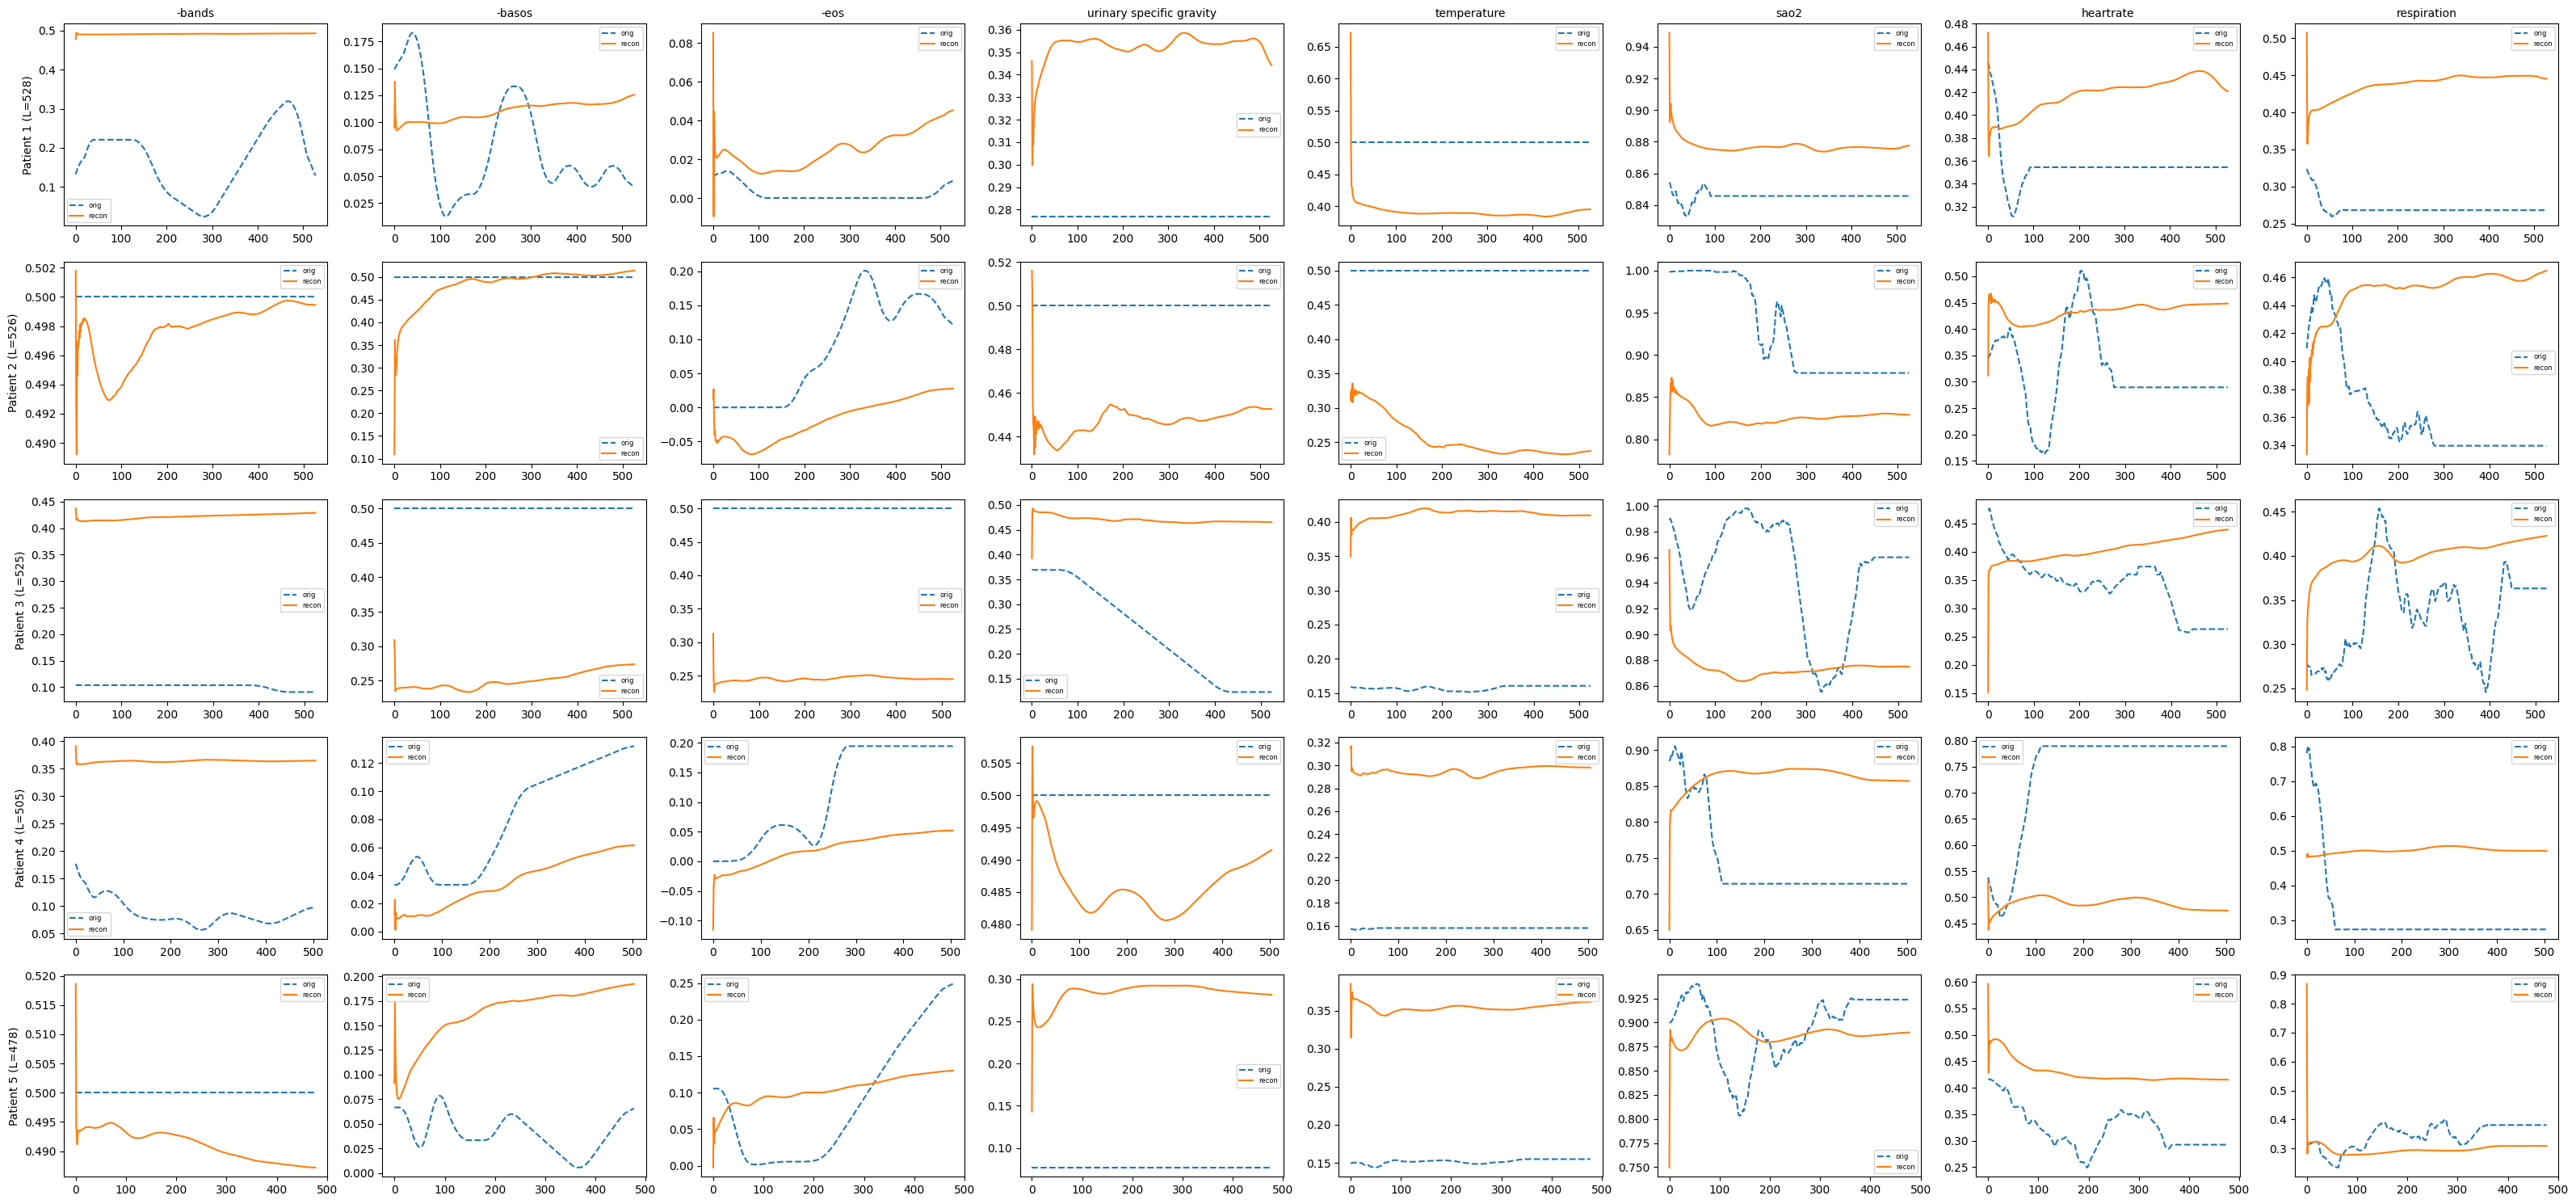

In [8]:
## 32
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]
selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 159263 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0335
  Std (overall): 0.5598
  Per-dim mean:
tensor([-1.1633e-01,  2.0995e-01, -8.0525e-02, -1.2301e-01, -8.5916e-01,
        -1.5130e-02,  7.3617e-01,  1.0188e-01,  9.2736e-03,  9.0215e-02,
        -5.7447e-02, -8.6018e-02,  2.0397e-01, -1.6533e-01, -4.8464e-01,
         7.1634e-04,  7.6096e-02, -6.8189e-02, -4.8573e-01,  9.4035e-02,
         2.4534e-02, -3.7983e-02, -8.6112e-02,  1.0239e-01, -3.8169e-02,
        -2.0664e-02,  1.5019e-02,  8.7119e-03,  1.2712e-01, -6.9950e-02,
         6.2096e-01, -5.2081e-02,  4.4462e-03,  1.6975e+00,  8.2329e-02,
         9.0513e-03, -9.3992e-02, -1.6052e+00,  8.9373e-02,  3.2556e-01,
         3.6343e-02, -1.0074e-01, -4.4298e-01,  6.6650e-01,  1.8936e-02,
         1.1586e-01,  1.3652e-01, -1.1826e-01, -4.4277e-02, -3.4108e-02,
         2.5933e-01, -1.1984e-01, -7.6286e-02, -2.4016e-01,  2.9901e-02,
         2.4637e-01, -9.1483e-02, -2.

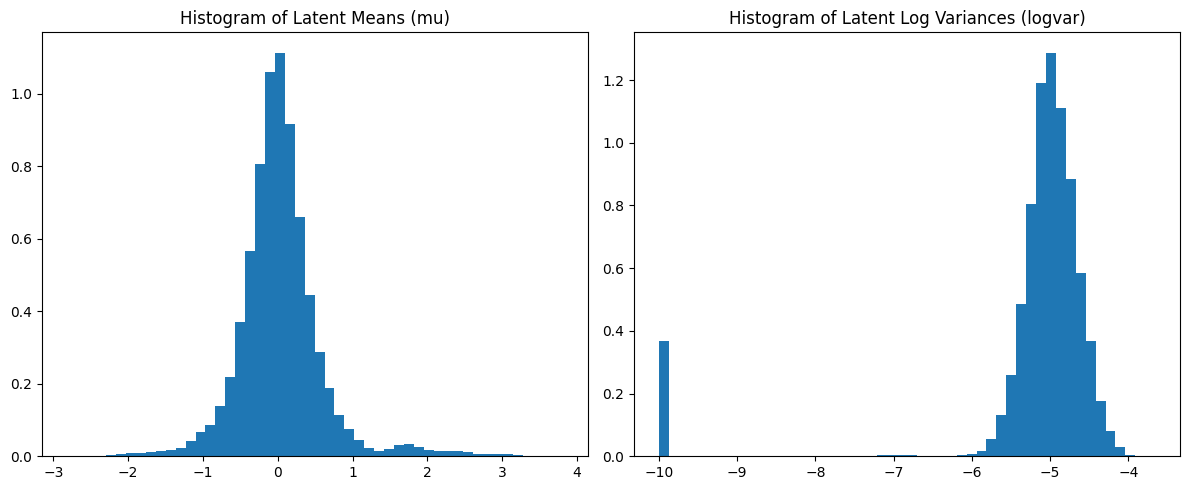

In [9]:
analyze_latent_stats(model3, train_loader, device, num_batches_to_analyze=20)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
stage3 = '/home/mei/nas/docker/thesis/data/model_results/baseline/resampled_30/stage3/best_joint.pth'
model3 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model3.load_state_dict(torch.load(stage3, map_location=device,weights_only=True))

<All keys matched successfully>

In [ ]:
from matplotlib.colors import LogNorm
def plot_som_activation_heatmap(heatmap, som_dim, cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        cmap=cmap,
        norm=LogNorm(vmin=max(heatmap.min(), 1e-3), vmax=heatmap.max()),
        annot=False,
        fmt="d",
        square=True,
        cbar_kws={"label": "Activation Count"}
    )
    plt.title("Overall SOM Activation")
    plt.xlabel("SOM Width")
    plt.ylabel("SOM Height")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


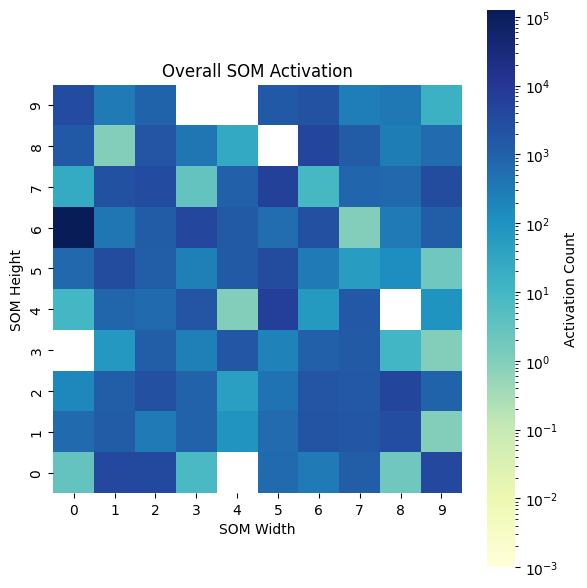

In [9]:
som_dim=(10,10)
activation_map = compute_som_activation_heatmap(model3, test_loader, device)
plot_som_activation_heatmap(activation_map,som_dim)

In [10]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_som_avg_category(heatmap, som_dim):
    """
    heatmap: HxW array of avg category (0,1,2,3) or NaN
    color bar:0,1,2,3
    """
    import numpy as np
    H, W = som_dim

    cmap = plt.get_cmap("YlGnBu", 4)
    # boundaries: [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = BoundaryNorm(np.arange(-0.5, 4), ncolors=cmap.N, clip=True)

    plt.figure(figsize=(W*0.6, H*0.6))
    ax = sns.heatmap(
        heatmap,
        cmap=cmap,
        norm=norm,
        annot=True,
        fmt=".0f",
        square=True,
        linewidths=.5,
        linecolor="gray",
        cbar_kws={
            "ticks": np.arange(4),          
            "boundaries": np.arange(-0.5,4),
            "spacing": "proportional",      
            "label": "Avg Category"
        }
    )

    # 强制 colorbar 仅显示整数标签
    cbar = ax.collections[0].colorbar
    cbar.set_ticklabels([str(i) for i in range(4)])

    plt.title("SOM Node Avg Category")
    plt.xlabel("SOM Width")
    plt.ylabel("SOM Height")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

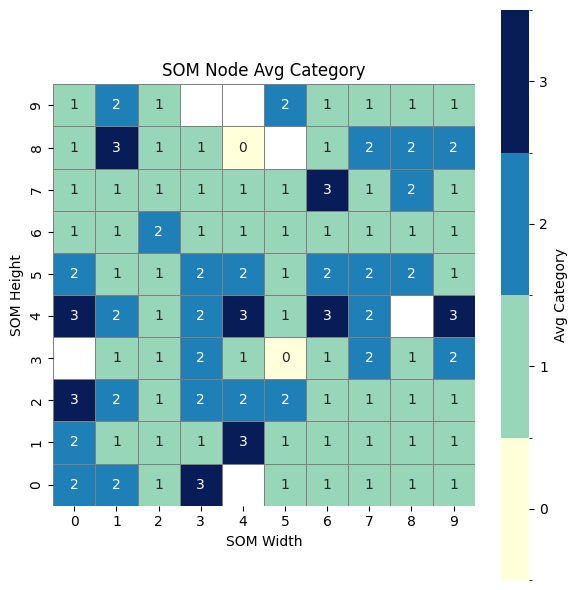

In [11]:
som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model3, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)